Train images: 961
Val images: 1203
Train objects: 1509
Val objects: 1932
Categories: [{'id': 1, 'name': 'pneumonia'}]


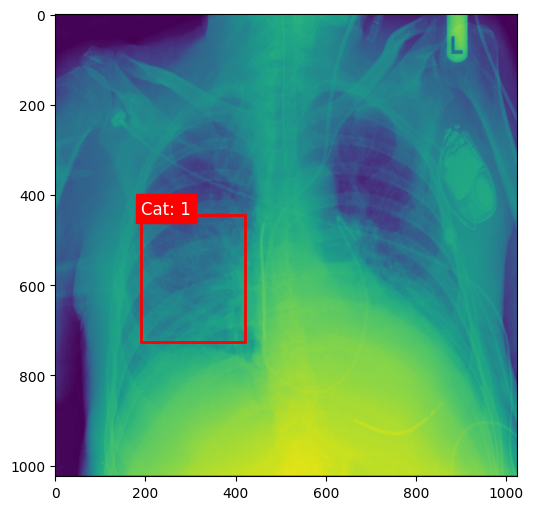

Overlap in train/val image IDs: 961
Train distribution: Counter({1: 1509})
Val distribution: Counter({1: 1932})


NameError: name 'preds' is not defined

In [1]:
# checkpoints.ipynb

# 1. Load Imports
import json
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

# 2. Annotation Inspection
def load_coco_annotations(ann_path):
    with open(ann_path, 'r') as f:
        ann = json.load(f)
    return ann

# Paths
image_dir = '/data/sundeep/Point-Beyond-Class/data/RSNA/RSNA_jpg'
train_ann_path = '/data/sundeep/Point-Beyond-Class/data/RSNA/cocoAnn/20p/instances_trainBox.json'
val_ann_path = '/data/sundeep/Point-Beyond-Class/data/RSNA/cocoAnn/instances_val.json'

# Load annotations
train_ann = load_coco_annotations(train_ann_path)
val_ann = load_coco_annotations(val_ann_path)

# Print stats
print("Train images:", len(train_ann['images']))
print("Val images:", len(val_ann['images']))
print("Train objects:", len(train_ann['annotations']))
print("Val objects:", len(val_ann['annotations']))
print("Categories:", train_ann['categories'])

# 3. Visualize a Random Sample
def plot_image_with_boxes(image_id, annotations, coco_ann):
    img_info = next(item for item in coco_ann['images'] if item['id'] == image_id)
    img_path = os.path.join(image_dir, img_info['file_name'])
    img = np.array(Image.open(img_path))
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(img)
    for ann in annotations:
        bbox = ann['bbox']
        xmin, ymin, w, h = bbox
        rect = plt.Rectangle((xmin, ymin), w, h, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin - 2, f"Cat: {ann['category_id']}", fontsize=12, color='white', backgroundcolor='red')
    plt.show()

# Pick random validation image and plot
rand_img = random.choice(val_ann['images'])
img_id = rand_img['id']
anns = [a for a in val_ann['annotations'] if a['image_id'] == img_id]
plot_image_with_boxes(img_id, anns, val_ann)

# 4. Check Train/Val Split Integrity
train_image_ids = set([img['id'] for img in train_ann['images']])
val_image_ids = set([img['id'] for img in val_ann['images']])
overlap_ids = train_image_ids.intersection(val_image_ids)
print("Overlap in train/val image IDs:", len(overlap_ids))

# 5. Print Category Distribution
from collections import Counter
cat_counts = Counter([ann['category_id'] for ann in train_ann['annotations']])
print("Train distribution:", cat_counts)
cat_counts_val = Counter([ann['category_id'] for ann in val_ann['annotations']])
print("Val distribution:", cat_counts_val)

# 6. Prediction vs Ground-Truth (Manual Inspection)
# Assumes: preds is a list of dicts {image_id, bbox, score, category_id}
# preds = load_your_predictions('preds.json')
def plot_preds_vs_gts(img_id, coco_ann, preds):
    img_info = next(item for item in coco_ann['images'] if item['id'] == img_id)
    img_path = os.path.join(image_dir, img_info['file_name'])
    img = np.array(Image.open(img_path))
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(img)
    # Plot GT boxes
    for ann in [a for a in coco_ann['annotations'] if a['image_id'] == img_id]:
        bbox = ann['bbox']
        xmin, ymin, w, h = bbox
        rect = plt.Rectangle((xmin, ymin), w, h, fill=False, color='green', linewidth=2)
        ax.add_patch(rect)
    # Plot predicted boxes
    for pred in [p for p in preds if p['image_id'] == img_id]:
        bbox = pred['bbox']
        xmin, ymin, w, h = bbox
        rect = plt.Rectangle((xmin, ymin), w, h, fill=False, color='blue', linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin - 2, f"Pred: {pred['score']:.2f}", fontsize=12, color='blue', backgroundcolor='white')
    plt.show()

# 7. Metric Calculation Check
# Use the official pycocotools for mAP calculation
# pip install pycocotools
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def eval_coco(gt_path, dt_path):
    coco_gt = COCO(gt_path)
    coco_dt = coco_gt.loadRes(dt_path)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

# Example:
# eval_coco('PATH_TO_VAL_ANN.json', 'PATH_TO_PREDICTIONS.json')

# 8. Save Sliced Predictions and Ground-truth (for sharing/debugging)
def save_json(obj, path):
    with open(path, 'w') as f:
        json.dump(obj, f)

sample_val_image = val_ann['images'][0]
sample_preds = [p for p in preds if p['image_id'] == sample_val_image['id']]
sample_gts = [a for a in val_ann['annotations'] if a['image_id'] == sample_val_image['id']]
save_json({'preds': sample_preds, 'gts': sample_gts}, 'sample_debug.json')


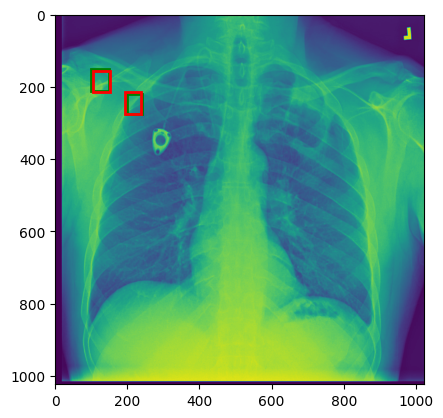

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_bbox(img_path, gt_bboxes, pred_bboxes):
    img = np.array(Image.open(img_path))
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    # Plot ground-truth boxes in green
    for box in gt_bboxes:
        x, y, w, h = box
        ax.add_patch(plt.Rectangle((x,y),w,h,edgecolor='green',fill=False,linewidth=2))
    # Plot predicted boxes in red
    for box in pred_bboxes:
        x, y, w, h = box
        ax.add_patch(plt.Rectangle((x,y),w,h,edgecolor='red',fill=False,linewidth=2))
    plt.show()

plot_bbox(
    '/data/sundeep/Point-Beyond-Class/data/RSNA/RSNA_jpg/000001.jpg',
    [[100, 150, 50, 60], [200, 220, 40, 55]],  # Example ground-truth boxes: x, y, w, h
    [[105, 155, 48, 58], [195, 215, 44, 60]]   # Example predicted boxes
)


In [1]:
import json
import math

with open('/data/sundeep/Point-Beyond-Class/data/RSNA/cocoAnn/20p/instances_trainBox.json') as f:
    annotations = json.load(f)["annotations"]

for ann in annotations:
    bbox = ann['bbox']  # [x, y, w, h]
    if any([b is None or (isinstance(b, float) and math.isnan(b)) or b==0 for b in bbox]):
        print("Corrupt bbox found:", bbox, "annotation_id:", ann['id'])


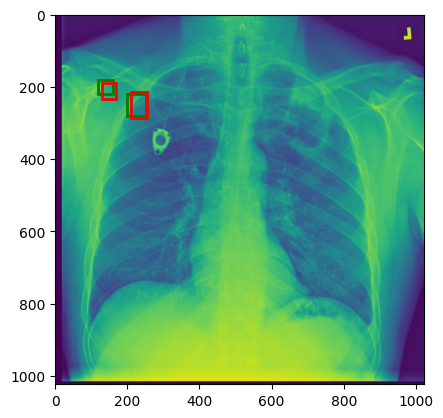

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_bbox(img_path, gt_bboxes, pred_bboxes):
    img = np.array(Image.open(img_path))
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    # Ground-truth boxes: Green
    for box in gt_bboxes:
        x, y, w, h = box
        ax.add_patch(plt.Rectangle((x, y), w, h, edgecolor='green', fill=False, linewidth=2, label='GT'))
    # Predicted boxes: Red
    for box in pred_bboxes:
        x, y, w, h = box
        ax.add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', fill=False, linewidth=2, label='Pred'))
    plt.show()

# Example with dummy numbers (replace with your data):
gt_boxes = [[120, 180, 40, 40], [200, 220, 52, 60]]
pred_boxes = [[130, 190, 38, 42], [210, 215, 45, 70]]
plot_bbox('/data/sundeep/Point-Beyond-Class/data/RSNA/RSNA_jpg/000001.jpg', gt_boxes, pred_boxes)
